In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brent, approx_fprime
from scipy.special import jn
import sympy as sp

In [2]:
# Line minimization routine
def linmin(func,p,x):
    f = lambda t : func(p + t*x)
    tmin = brent(f)
    return p + tmin*x, f(tmin)

In [3]:
def fmin_coord(func,p,tol):
    n = len(p)
    p = np.array(p)
    pcurr, valcurr = p, func(p)
    xi = np.eye(n)
    iter_count = 0
    p_his = [pcurr]
    while True:
        iter_count += 1
        for i in range(n):
            xit = xi[:,i]
            pcurr, valnew = linmin(func,pcurr,xit)
            p_his.append(pcurr)
        if np.abs(valcurr-valnew) <= tol:
            return pcurr, valnew , iter_count, p_his
        if iter_count > 200:
            raise Exception("Maximum Iteration of 200 is reached")
        valcurr = valnew

In [4]:
def powell(func,p,xi,tol):
    n = len(p)
    p = np.array(p)
    xi = np.array(xi)
    iter_count = 0
    fret = func(p)
    pt = p.copy()
    p_his = []
    while True:
        fp = fret
        for i in range(n):
            xit = xi[:,i]
            p_his.append(p)
            p, fp = linmin(func,p,xit)

        if np.abs(fp-fret) <= tol:
            return p, func(p), iter_count, xi, p_his

        # if iter_count > 200:
        #     raise Exception("Maximum Iteration of 200 is reached")

        for i in range(n-1):
            xi[:,i] = xi[:,i+1]
        xit = p - pt
        xi[:,n-1] = xit
        p_his.append(p)
        p,fret = linmin(func,p,xit)
        pt = p.copy()
        iter_count += 1

In [5]:
def modified_powell(func,p,xi,tol):
    n = len(p)
    p = np.array(p)
    xi = np.array(xi)
    iter_count = 0
    fret = func(p)
    pt = p.copy()
    p_his = []
    while True:
        fp = fret
        del_f = 0
        ibig = -1
        for i in range(n):
            xit = xi[:,i]
            p_his.append(p)
            p, f_new = linmin(func,p,xit)
            if fp - f_new > del_f:
                del_f = fp - f_new
                ibig = i
            fp = f_new

        # if 2*abs(fp-fret) <= ftol*(abs(fp)+abs(fret))+np.finfo(float).eps:
        #     return p, func(p), iter_count, xi, p_his
        
        if np.abs(fp-fret) <= tol:
            return p, func(p), iter_count, xi, p_his

        # if iter_count > 200:
        #     raise Exception("Maximum Iteration of 200 is reached")

        ptt = 2*p - pt
        xit = p - pt
        fptt = func(ptt)

        if fptt < fret:
            t = 2*(fret-2*fp+fptt)*(fret-fp-del_f)**2 - del_f*(fret-fptt)**2
            if t < 0:
                p_his.append(p)
                p, fret = linmin(func,p,xit)
                xi[:,ibig] = xit
        pt = p.copy()
        iter_count += 1

In [6]:
def steepest_descent(func,grad,p,tol):
    p = np.array(p)
    pcurr, valcurr = p, func(p)
    iter_count = 0
    p_his = [pcurr]
    while True:
        curr_grad = -grad(pcurr)
        curr_grad = curr_grad/np.linalg.norm(curr_grad)
        pcurr, valnew = linmin(func,pcurr,curr_grad)
        p_his.append(pcurr)
        if np.abs(valcurr-valnew) < tol:
            return pcurr, valnew , iter_count, p_his
        # if iter_count > 200:
        #     raise Exception("Maximum Iteration of 200 is reached")
        valcurr = valnew
        iter_count += 1

In [7]:
# Fletcher-Reeves 
def conjugate_gradient_fr(func,grad,p,tol):
    p = np.array(p)
    pcurr, valcurr = p, func(p)
    iter_count = 0
    p_his = [pcurr]
    g = -grad(pcurr)
    h = g
    g_his, h_his = [g],[h]
    while True:
        pcurr, valnew = linmin(func,pcurr,h)
        p_his.append(pcurr)
        if np.abs(valcurr-valnew) < tol or np.linalg.norm(h) < tol:
            return pcurr, valnew , iter_count, p_his, g_his, h_his
        # if iter_count > 200:
        #     raise Exception("Maximum Iteration of 200 is reached")
        gnew = -grad(pcurr)
        gamma = np.dot(gnew,gnew)/np.dot(g,g)
        g = gnew
        h = g + gamma*h
        g_his.append(g)
        h_his.append(h)
        valcurr = valnew
        iter_count += 1

In [8]:
# Polak-Ribiere
def conjugate_gradient_pr(func,grad,p,tol):
    p = np.array(p)
    pcurr, valcurr = p, func(p)
    iter_count = 0
    p_his = [pcurr]
    g = -grad(pcurr)
    h = g
    g_his, h_his = [g],[h]
    while True:
        pcurr, valnew = linmin(func,pcurr,h)
        p_his.append(pcurr)
        if np.abs(valcurr-valnew) < tol or np.linalg.norm(h) < tol:
            return pcurr, valnew , iter_count, p_his, g_his, h_his
        # if iter_count > 200:
        #     raise Exception("Maximum Iteration of 200 is reached")
        gnew = -grad(pcurr)
        gamma = max(0,np.dot(gnew-g,gnew)/np.dot(g,g))
        g = gnew
        h = g + gamma*h
        g_his.append(g)
        h_his.append(h)
        valcurr = valnew
        iter_count += 1

# Minimization of Nice function

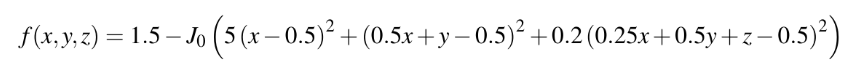

In [9]:
# defining the function
def f_nice(X):
    x = X[0]
    y = X[1]
    z = X[2]
    arg = 5*(x-0.5)**2 + (0.5*x + y -0.5)**2 + 0.2*(0.25*x + 0.5*y + z - 0.5)**2
    return 1.5 - jn(0,arg)

In [10]:
# defining the gradient of the function
def grad_f_nice(X):
    x = X[0]
    y = X[1]
    z = X[2]
    arg = 5*(x-0.5)**2 + (0.5*x + y -0.5)**2 + 0.2*(0.25*x + 0.5*y + z - 0.5)**2
    gradx = jn(1,arg)*(10*(x-0.5) + (0.5*x+y-0.5) + 0.1*(0.25*x + 0.5*y + z - 0.5))
    grady = jn(1,arg)*(2*(0.5*x + y -0.5) + 0.2*(0.25*x + 0.5*y + z - 0.5))
    gradz = jn(1,arg)*(0.4*(0.25*x + 0.5*y + z - 0.5))
    return np.array([gradx,grady,gradz])

### Along coordinate directions

In [11]:
p = [0,0,0]
tol = 1e-8

pmin, fmin, n_iter, his = fmin_coord(f_nice,p,tol)

print('Point of minimum : ',pmin)
print('Minimum value of the function : ',fmin)
print('Number of iterations : ',n_iter)

Point of minimum :  [0.49984726 0.25012492 0.24992242]
Minimum value of the function :  0.5000000000000036
Number of iterations :  3


In [12]:
his

[array([0, 0, 0]),
 array([0.5273159, 0.       , 0.       ]),
 array([0.5273159 , 0.26015156, 0.        ]),
 array([0.5273159 , 0.26015156, 0.23809525]),
 array([0.49910036, 0.26015156, 0.23809525]),
 array([0.49910036, 0.2515836 , 0.23809525]),
 array([0.49910036, 0.2515836 , 0.24943279]),
 array([0.49984726, 0.2515836 , 0.24943279]),
 array([0.49984726, 0.25012492, 0.24943279]),
 array([0.49984726, 0.25012492, 0.24992242])]

### Powell Method

In [13]:
# using modified powell method
p = [0,0,0] 
xi = np.eye(len(p))
tol = 1e-9

pmin, fmin, n_iter, xi_final,p_his = modified_powell(f_nice,p,xi,tol)

print('Point of minimum : ',pmin)
print('Minimum value of the function : ',fmin)
print('Number of iterations : ',n_iter)
print('Final set of directions : \n',xi_final)

Point of minimum :  [0.4997356  0.25021025 0.24993782]
Minimum value of the function :  0.5000000000000316
Number of iterations :  2
Final set of directions : 
 [[-0.02821554  0.          0.        ]
 [-0.00856796  1.          0.        ]
 [ 0.01133754  0.          1.        ]]


In [14]:
# using powell method
p = [0,0,0] 
xi = np.eye(len(p))
tol = 1e-9

pmin, fmin, n_iter, xi_final,p_his = powell(f_nice,p,xi,tol)

print('Point of minimum : ',pmin)
print('Minimum value of the function : ',fmin)
print('Number of iterations : ',n_iter)
print('Final set of directions : \n',xi_final)

Point of minimum :  [0.49986905 0.25085433 0.24892925]
Minimum value of the function :  0.5000000000001598
Number of iterations :  2
Final set of directions : 
 [[ 0.          0.5273159  -0.00144196]
 [ 0.          0.26015156  0.00354132]
 [ 1.          0.23809525  0.02186014]]


### Steepest Descent

In [15]:
p = [0,0,0]
tol = 1e-11

pmin, fmin, n_iter, his = steepest_descent(f_nice,grad_f_nice,p,tol)

print('Point of minimum : ',pmin)
print('Minimum value of the function : ',fmin)
print('Number of iterations : ',n_iter)

Point of minimum :  [0.50011198 0.25081468 0.24319935]
Minimum value of the function :  0.5000000000199104
Number of iterations :  34


In [16]:
his

[array([0, 0, 0]),
 array([0.52338877, 0.10373471, 0.01886086]),
 array([0.48798774, 0.27129025, 0.07968644]),
 array([0.50245995, 0.2715252 , 0.08746218]),
 array([0.49039195, 0.26580602, 0.11009594]),
 array([0.50217305, 0.26638917, 0.11652483]),
 array([0.49216128, 0.26264253, 0.13521133]),
 array([0.50181276, 0.2631973 , 0.14049359]),
 array([0.49357846, 0.26030728, 0.15584241]),
 array([0.5014927 , 0.26077712, 0.16017669]),
 array([0.49473446, 0.25844203, 0.1727703 ]),
 array([0.50122544, 0.25883027, 0.1763256 ]),
 array([0.49568145, 0.25692183, 0.18665588]),
 array([0.50100532, 0.25724082, 0.189572  ]),
 array([0.49645799, 0.25567685, 0.19804504]),
 array([0.50082462, 0.25593859, 0.20043686]),
 array([0.49709485, 0.25465607, 0.20738645]),
 array([0.50067636, 0.25487077, 0.20934823]),
 array([0.49761719, 0.2538189 , 0.21504831]),
 array([0.50055464, 0.253995  , 0.21665731]),
 array([0.49804537, 0.25313211, 0.22133359]),
 array([0.50045491, 0.25327659, 0.22265321]),
 array([0.49839

### Conjugate Gradients

In [17]:
# using Fletcher-Reeves Conjugate gradient method

p = [0,0,0]
tol = 1e-11

pmin, fmin, n_iter, p_his, g_his, h_his = conjugate_gradient_fr(f_nice,grad_f_nice,p,tol)

print('Point of minimum : ',pmin)
print('Minimum value of the function : ',fmin)
print('Number of iterations : ',n_iter)

Point of minimum :  [0.49961519 0.25058149 0.24609457]
Minimum value of the function :  0.5000000000033232
Number of iterations :  12


In [18]:
# using Polak-Ribiere Conjugate gradient method

p = [0,0,0]
tol = 1e-11

pmin, fmin, n_iter, p_his, g_his, h_his = conjugate_gradient_pr(f_nice,grad_f_nice,p,tol)

print('Point of minimum : ',pmin)
print('Minimum value of the function : ',fmin)
print('Number of iterations : ',n_iter)

Point of minimum :  [0.50021065 0.24950361 0.24716016]
Minimum value of the function :  0.5000000000012293
Number of iterations :  8


### Hessian Matrix and its eigenvectors

In [19]:
x, y, z = sp.symbols('x y z')

arg = 5*(x-0.5)**2 + (0.5*x + y -0.5)**2 + 0.2*(0.25*x + 0.5*y + z - 0.5)**2

f = 1.5 - sp.besselj(0, arg)

d2f_dx2 = sp.diff(f, x, 2)
d2f_dy2 = sp.diff(f, y, 2)
d2f_dz2 = sp.diff(f, z, 2)
d2f_dxdy = sp.diff(f, x, y)
d2f_dxdz = sp.diff(f, x, z)
d2f_dydz = sp.diff(f, y, z)

point = {x: 0.5, y: 0.25, z: 0.25}

H11 = float(d2f_dx2.evalf(subs=point))
H12 = float(d2f_dxdy.evalf(subs=point))
H13 = float(d2f_dxdz.evalf(subs=point))
H22 = float(d2f_dy2.evalf(subs=point))
H23 = float(d2f_dydz.evalf(subs=point))
H33 = float(d2f_dz2.evalf(subs=point))

Hessian = np.array([
    [H11, H12, H13],
    [H12, H22, H23],
    [H13, H23, H33]
])

In [20]:
Hessian

array([[ 2.20429850e-032, -7.65557153e-033,  1.82278050e-304],
       [-7.65557153e-033,  1.69867021e-033, -2.27847563e-305],
       [ 1.82278050e-304, -2.27847563e-305,  2.38666903e-155]])

In [21]:
eigenvalues, eigenvectors = np.linalg.eig(Hessian)

In [22]:
eigenvectors

array([[ 9.48420139e-001, -3.17016151e-001,  6.38820058e-273],
       [-3.17016151e-001, -9.48420139e-001,  4.22036499e-272],
       [ 7.54810869e-273,  2.25817463e-272,  1.00000000e+000]])

$\mathbf{v}_1 = \begin{bmatrix} 0.948 \\ -0.317 \\ 0 \end{bmatrix}, \quad
\mathbf{v}_2 = \begin{bmatrix} -0.317 \\ -0.948 \\ 0 \end{bmatrix}, \quad
\mathbf{v}_3 = \begin{bmatrix} 0 \\ 0 \\ 1 \end{bmatrix}$

In [23]:
eigenvalues

array([ 2.46019141e-032, -8.60258814e-034,  2.38666903e-155])

# Minimization of Difficult function

In [24]:
def u(x,y):
    alpha = 5*(1.5*np.sqrt(x**2 + y**2) - 1.5)
    return np.cos(alpha)*x + np.sin(alpha)*y - 5

def v(x,y):
    alpha = 5*(1.5*np.sqrt(x**2 + y**2) - 1.5)
    return -np.sin(alpha)*x + np.cos(alpha)*y - 5

def f_difficult(X):
    x = X[0]
    y = X[1]
    return u(x,y)**2 + v(x,y)**2
    
def grad_f_difficult(X):
    return approx_fprime(X,f_difficult,1e-6)

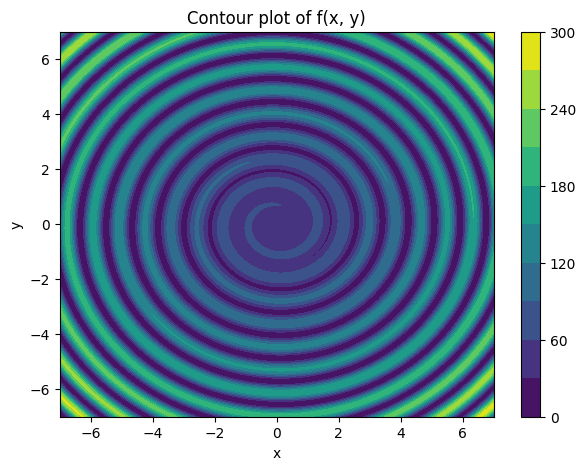

In [25]:
x = np.linspace(-7, 7, 1000)
y = np.linspace(-7, 7, 1000)
X, Y = np.meshgrid(x, y)
f = lambda x,y : f_difficult(np.array([x,y]))
Z = f(X, Y)

plt.figure(figsize=(7,5))
cp = plt.contourf(X, Y, Z, levels=10)
plt.colorbar(cp)
plt.title("Contour plot of f(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

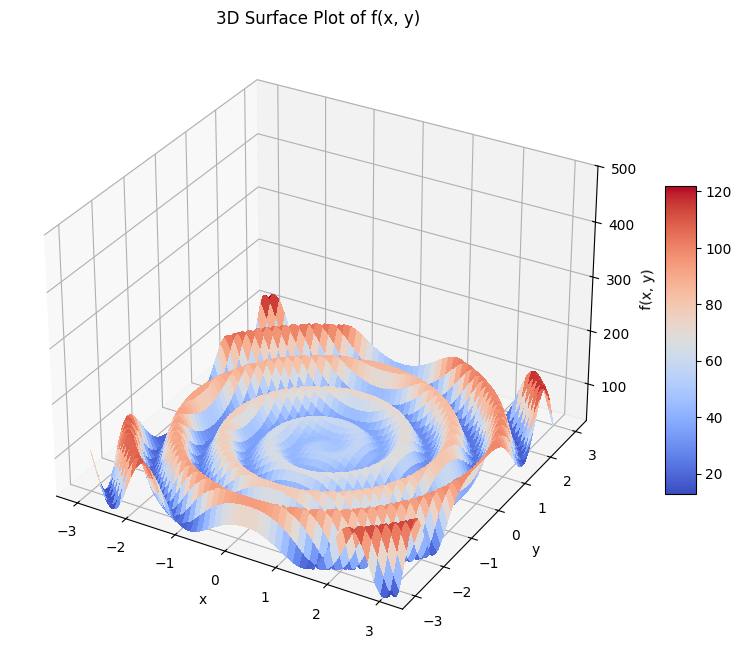

In [26]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(-3, 3, 1000)
y = np.linspace(-3, 3, 1000)
X, Y = np.meshgrid(x, y)

Z = f(X, Y)

surf = ax.plot_surface(X, Y, Z, cmap='coolwarm', antialiased=False)
ax.set_title("3D Surface Plot of f(x, y)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x, y)")
ax.set_zlim(30,500)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.show()

### Powell Method

In [27]:
# using modified powell method
p = [1,1] 
xi = np.eye(len(p))
tol = 1e-9

pmin, fmin, n_iter, xi_final,p_his = modified_powell(f_difficult,p,xi,tol)

print('Point of minimum : ',pmin)
print('Minimum value of the function : ',fmin)
print('Number of iterations : ',n_iter)
print('Final set of directions : \n',xi_final)

Point of minimum :  [-4.89724448  5.10063858]
Minimum value of the function :  1.164879440771643e-09
Number of iterations :  2833
Final set of directions : 
 [[-8.00324049e-04  3.62465505e-06]
 [-7.39330670e-04  6.78512855e-08]]


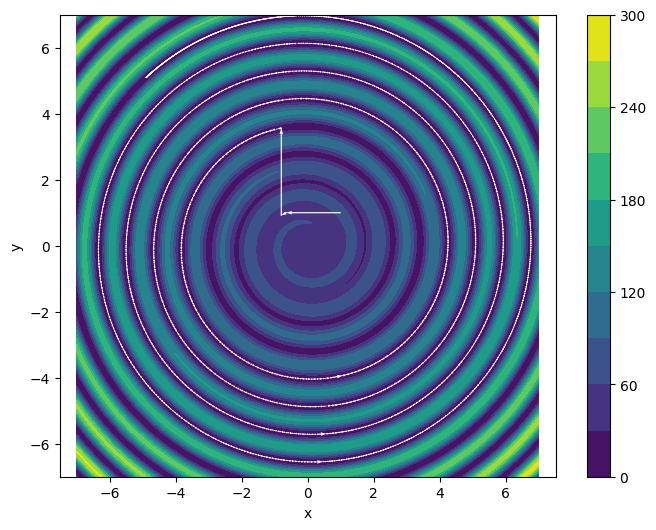

In [28]:
x = np.linspace(-7, 7, 1000)
y = np.linspace(-7, 7, 1000)
X, Y = np.meshgrid(x, y)
f = lambda x,y : f_difficult(np.array([x,y]))
Z = f(X, Y)

plt.figure(figsize=(8,6))
cp = plt.contourf(X, Y, Z, levels=10)
plt.colorbar(cp)

p_his = np.array(p_his)
x, y = p_his[:-1, 0], p_his[:-1, 1]
dx, dy = np.diff(p_his[:, 0]), np.diff(p_his[:, 1])

plt.quiver(x, y, dx, dy, angles='xy', scale_units='xy', scale=1, color='white')
#plt.scatter(p_his[:, 0], p_his[:, 1], color='r', label='Points',s=1)

plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

In [29]:
# using powell method
p = [1,1] 
xi = np.eye(len(p))
tol = 1e-9

pmin, fmin, n_iter, xi_final,p_his = powell(f_difficult,p,xi,tol)

print('Point of minimum : ',pmin)
print('Minimum value of the function : ',fmin)
print('Number of iterations : ',n_iter)
print('Final set of directions : \n',xi_final)

Point of minimum :  [-4.89852568  5.09945383]
Minimum value of the function :  8.217170901700249e-12
Number of iterations :  1285
Final set of directions : 
 [[-0.00079106 -0.00056955]
 [-0.00072982 -0.00052665]]


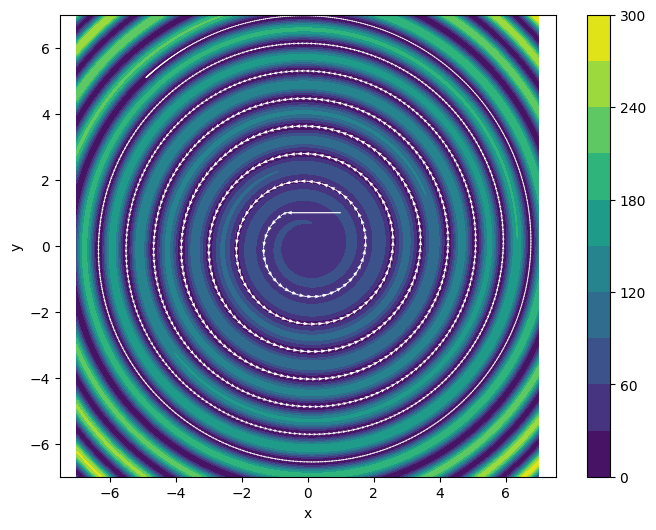

In [30]:
x = np.linspace(-7, 7, 1000)
y = np.linspace(-7, 7, 1000)
X, Y = np.meshgrid(x, y)
f = lambda x,y : f_difficult(np.array([x,y]))
Z = f(X, Y)

plt.figure(figsize=(8,6))
cp = plt.contourf(X, Y, Z, levels=10)
plt.colorbar(cp)

p_his = np.array(p_his)
x, y = p_his[:-1, 0], p_his[:-1, 1]
dx, dy = np.diff(p_his[:, 0]), np.diff(p_his[:, 1])

plt.quiver(x, y, dx, dy, angles='xy', scale_units='xy', scale=1, color='white')
# plt.scatter(p_his[:, 0], p_his[:, 1], color='r', label='Points',s=1)

plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

### Conjugate Gradients

In [31]:
# using Fletcher-Reeves Conjugate gradient method

p = [1,1]
tol = 1e-9

pmin, fmin, n_iter, p_his, g_his, h_his = conjugate_gradient_fr(f_difficult,grad_f_difficult,p,tol)

print('Point of minimum : ',pmin)
print('Minimum value of the function : ',fmin)
print('Number of iterations : ',n_iter)

Point of minimum :  [-3.86806681  5.88994043]
Minimum value of the function :  0.0006031464677970081
Number of iterations :  1934


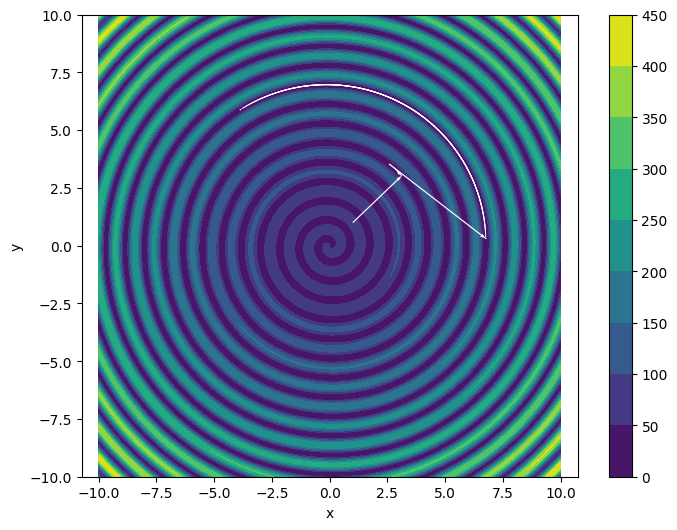

In [32]:
x = np.linspace(-10, 10, 1000)
y = np.linspace(-10, 10, 1000)
X, Y = np.meshgrid(x, y)
f = lambda x,y : f_difficult(np.array([x,y]))
Z = f(X, Y)

plt.figure(figsize=(8,6))
cp = plt.contourf(X, Y, Z, levels=10)
plt.colorbar(cp)

p_his = np.array(p_his)
x, y = p_his[:-1, 0], p_his[:-1, 1]
dx, dy = np.diff(p_his[:, 0]), np.diff(p_his[:, 1])

plt.quiver(x, y, dx, dy, angles='xy', scale_units='xy', scale=1, color='white')
#plt.scatter(p_his[:, 0], p_his[:, 1], color='r', label='Points',s=1)

plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

In [33]:
# using Polak-Ribiere Conjugate gradient method

p = [1,1]
tol = 1e-9

pmin, fmin, n_iter, p_his, g_his, h_his = conjugate_gradient_pr(f_difficult,grad_f_difficult,p,tol)

print('Point of minimum : ',pmin)
print('Minimum value of the function : ',fmin)
print('Number of iterations : ',n_iter)

Point of minimum :  [-1.9172185   6.73857645]
Minimum value of the function :  0.004234300649251819
Number of iterations :  538


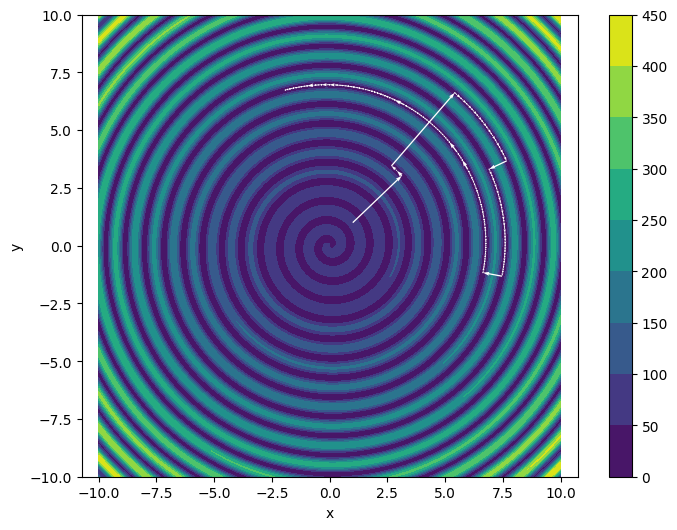

In [34]:
x = np.linspace(-10, 10, 1000)
y = np.linspace(-10, 10, 1000)
X, Y = np.meshgrid(x, y)
f = lambda x,y : f_difficult(np.array([x,y]))
Z = f(X, Y)

plt.figure(figsize=(8,6))
cp = plt.contourf(X, Y, Z, levels=10)
plt.colorbar(cp)

p_his = np.array(p_his)
x, y = p_his[:-1, 0], p_his[:-1, 1]
dx, dy = np.diff(p_his[:, 0]), np.diff(p_his[:, 1])

plt.quiver(x, y, dx, dy, angles='xy', scale_units='xy', scale=1, color='white')
#plt.scatter(p_his[:, 0], p_his[:, 1], color='r', label='Points',s=1)

plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

In [35]:
for i in range(-12,0,2):
    h_,g_ = h_his[i-2:i],g_his[i-2:i]
    print(g_[1].dot(g_[0]))
    print(g_[1].dot(h_[0]))

0.0014103454663387267
0.0014103454663387267
-1.4030479691722937e-05
1.4072459638912936e-06
0.3204905042499598
0.04342478026667784
0.0009811313731023874
0.0009811313731023874
-1.204752366247141e-05
1.7247636060095235e-06
0.3834067490447821
0.06633071772562715
